# mapQC quick-start

Here, we provide a quick introduction to how to run mapQC. For more details on parameter settings, detailed exploration of the results, trouble-shooting etc., see the tutorial notebook [mapqc_detailed](./mapqc_detailed.ipynb).

## Preparation

Let's load our packages:

In [1]:
import scanpy as sc
import mapqc

### Input data requirements (skip if running with test dataset):

If you would like to try out mapQC on your own data, here is a description of the input data requirements. You can skip this if you just want to go through the tutorial with the test data, as provided below.

In short, you need one AnnData object, including:
- A large scale reference, including only its healthy/control cells.
- A mapped query dataset, with healthy/control cells (must-have) and case/perturbed cells (if you have them).
- Metadata (see below)
- A mapping-derived embedding of both the reference and the query

1. **Reference**: MapQC is meant to evaluate the mapping of a given dataset to an existing, large-scale reference. It assumes the reference more or less covers the diversity of the control population (e.g. diversity among healthy individuals for the case of human data, or of unperturbed organoids generated with a wide array of protocols for an organoid dataset). Therefore, a mapping of a single dataset to another single dataset is likely to not fulfill these assumptions, and mapQC is not guaranteed to work well. MapQC runs on a scanpy AnnData object, that includes the *control* cells from the reference (i.e. no perturbed or diseased cells!) and *no perturbed/diseased/etc.* cells in the reference. Make sure to exclude these before running mapQC.

2. **Query**: The query (the dataset mapped to the reference) is expected to have both control and case samples. MapQC can also be run without case samples in the query, but it should always include controls. The query cells should be in the same AnnData object as the reference.

3. **Required Metadata**: Several metadata columns need to be present in your adata.obs:

   The following need a value for every cell from both the reference and the query. Column names can be set as wanted:
   - A "study" key, specifying from which study/dataset each cell in the reference and query came. The query is assumed to come from a single study. If the query includes multiple studies, map these separately and run mapQC on each of them separately.
   - A "sample" key, specifying from which biological sample a given cell came.
   - A reference versus query key, specifying for each cell whether it is from the reference or the query.

   And optionally:
   - A grouping of all your cells, e.g. a clustering run on your mapping embedding. If this is provided, mapQC will sample cells proportional to those groups instead of taking randomly sampled cells to choose its neighborhood sample cells. Providing a grouping might help better covering the full embedding space (especially helpful for rare cell types) when running mapQC.

   And for the query:
   - A "condition" key, specifying for the query what condition (case/control etc.) each cell belongs to, e.g. the disease of the patient from which the sample came or if it was a control.

4. **Embedding Data**: Your adata object needs to include the mapped embedding, including coordinates for both the reference and the query. These can be stored either in adata.X or in adata.obsm.

### Download and load test data

We can download test data from the mapQC github page as follows, or you can download it manually beforehand using the link from the command below. This mock dataset includes a subset of cells (stromal cells) from the Human Lung Cell Atlas [Sikkema et al., 2023](https://www.nature.com/articles/s41591-023-02327-2), and a mapped query including IPF and control samples [Tsukui et al., 2020](https://www.nature.com/articles/s41467-020-15647-5). We subset the number of latent dimensions to 10 to make the file and the calculations below more lightweight.

for linux/unix etc. (remove '#' before running)

In [2]:
# !wget -O mapped_q_and_r.h5ad "https://raw.githubusercontent.com/theislab/mapqc/main/tests/data/input/mapped_q_and_r.h5ad"

zsh:1: command not found: wget


for windows/macOS:

In [11]:
# !curl -L -o mapped_q_and_r.h5ad "https://raw.githubusercontent.com/theislab/mapqc/main/tests/data/input/mapped_q_and_r.h5ad"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.4M  100 14.4M    0     0  7859k      0  0:00:01  0:00:01 --:--:-- 7861k


Now load the data (adjust the path if necessary)

In [12]:
adata = sc.read_h5ad("./mapped_q_and_r.h5ad")

In [13]:
adata.shape

(35888, 10)

## Run MapQC

Now, let's run mapQC.

In [14]:
mapqc.run_mapqc(
    adata=adata,
    adata_emb_loc="X",  # our mapped embedding is in adata.X
    ref_q_key="r_or_q",  # .obs column with reference/query information
    q_cat="q",  # category for query
    r_cat="r",  # category for reference
    sample_key="sample",  # .obs column with sample information
    n_nhoods=100,  # number of neighborhoods to use for calculation of mapQC scores
    k_min=500,  # minimum neighborhood size
    k_max=5000,  # maximum neighborhood size
    study_key="study",  # .obs column with study/dataset information
    grouping_key="leiden",  # .obs column with a grouping of the data (not required)
    seed=10,  # set the seed for reproducibility
)

The run_mapqc() command has added a few columns to your adata object:  'mapqc_score', 'mapqc_filtering', 'mapqc_nhood_number', 'mapqc_nhood_filtering', 'mapqc_k'. The most important one is mapqc_score, which includes a mapqc_score for all your query cells that were sampled, and that passed filtering.

In [15]:
adata

AnnData object with n_obs × n_vars = 35888 × 10
    obs: 'study', 'donor_id', 'sample', 'r_or_q', 'lung_condition', 'leiden', 'ann_level_3', 'ann_level_4', 'mapqc_score', 'mapqc_filtering', 'mapqc_nhood_number', 'mapqc_nhood_filtering', 'mapqc_k'
    uns: 'neighbors', 'umap', 'mapqc_params'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

We will now evaluate the output, which will give you some summary statistics. The evaluation is split into control and case, and so here we need to specify the control and case categories of your specific query:

In [16]:
stats = mapqc.evaluate(
    adata,
    case_control_key="lung_condition",  # the .obs column that includes information of the case/control status of each cell (i.e. the subject it came from)
    case_cats=["IPF"],  # a list containing all case categories in your query data
    control_cats=["Healthy"],  # a list containing all control categories in your query data
)

61.0% of neighborhoods passed filtering (61 out of 100).
92.6% of cells were sampled (29617 out of 31990).
95.5% of sampled cells passed filtering (28291 out of 29617 sampled cells).
Percentage of Control (Healthy) cells (that passed filtering) distant to the reference (mapQC score > 2): 3.1%
Percentage of Case (IPF) cells (that passed filtering) distant to the reference (mapQC score > 2): 8.2%


## Plot mapQC results:

We can start plotting our results once we have run both mapqc.run() and mapqc.evaluate(), as shown above.

First, let's plot the umaps, subset to reference + query controls (left) or reference + query case cells (right), colored by mapQC score. Here, we have split the mapQC scores in normal (<=2, close to the reference) and high (>2, distant from the reference). Conistently high mapQC scores in the query controls indicate that the dataset might not have been successfully integrated into the reference. In contrast, generally low mapQC scores in the controls indicate a good-quality mapping.<br>
If the mapping looks good based on the control, and we see high mapQC scores in the case data, the high query-specific mapQC scores likely indicates a disease-specific cell state.

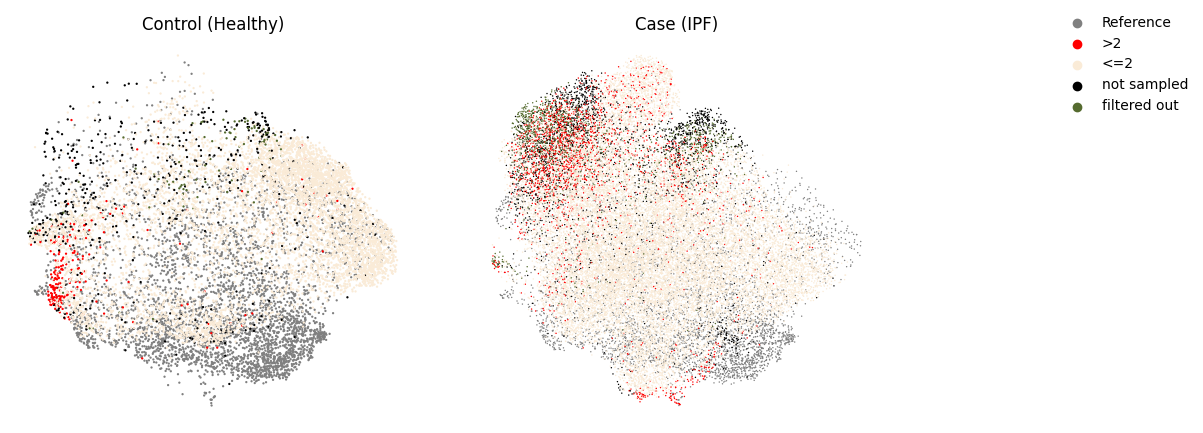

In [9]:
mapqc.pl.umap.mapqc_scores_binary(adata)

We can plot the mapQC scores without binarizing them as well. This is a bit more difficult to interpret visually though, so the plot above is a good first check.

/ictstr01/groups/ml01/code/lisa.sikkema/mapqc/src/mapqc/plotting/umap.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=(0.5, 0.5, 0.5, 1.0), marker="o", label="Reference"),


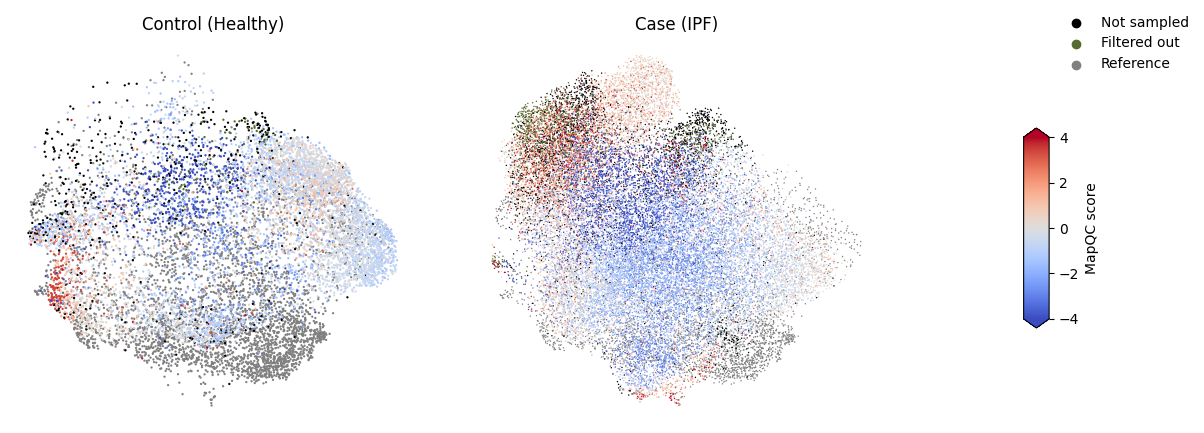

In [10]:
mapqc.pl.umap.mapqc_scores(adata)

Of course, we can also use standard scanpy plotting to plot general metadata of interest, e.g. your cell type labels. Our "ann_level_4" column includes cell type labels from the reference (at level 4 resolution, see the reference HLCA publication), and labels transfered from the reference to the query for the query.

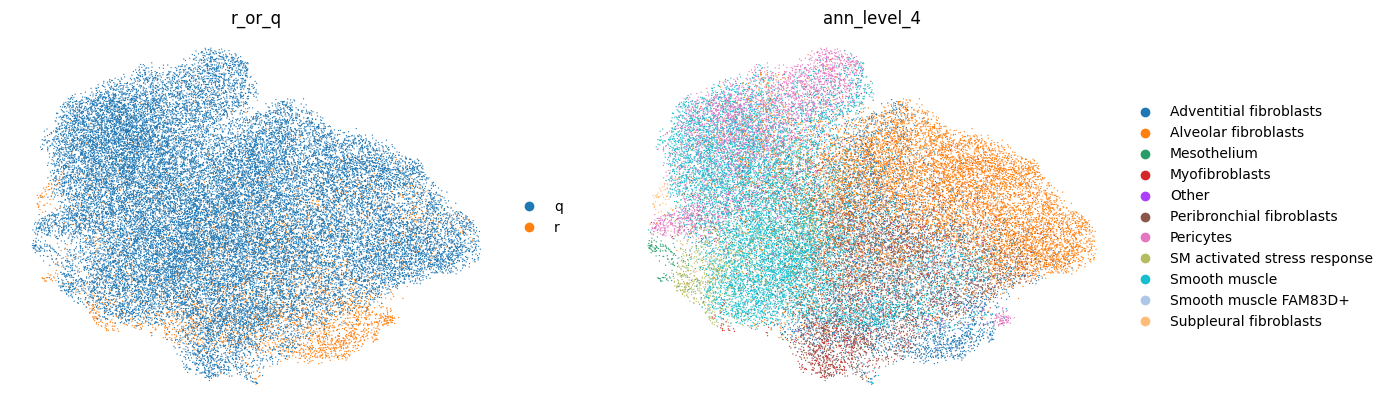

In [11]:
sc.pl.umap(adata, color=["r_or_q", "ann_level_4"], frameon=False)

Now let's look at our mapQC scores in a more quantitative way. We can check per group of cells how high the scores are, e.g. per cell type annotations. The whiskers in these boxplots extend to the 5th and 95th percentile for each box. <br>
In the plot below, we can see a couple of things. 
1. In general, most cell types show low (<2) mapQC scores for the controls, i.e. their upper whisker, i.e. the 95th percentile, is below or very close to the >2 dashed red line. This suggests the mapping successfully removed batch effects from the query. The only exception is the "SM activated/stress response" label, which has high mapQC scores in the controls, as could also be seen from the UMAPs above. We should therefore disregard these cells from both cases and controls in downstream analysis, or analyze them with caution, as they likely still contain batch effects in the embedding.
2. We see a few cell types that do show high mapQC scores in the query, but not in the control. These cell types are likely to show disease-specific phenotypic changes. For example, pericytes and smooth muscle cells show high mapQC scores in a subset of cells from the IPF samples. This not only gives us interesting pointers for where to start our data analysis, but also tells us the query data was not over-integrated during the mapping (i.e. the mapping did not remove all query-specific variation in the data).
3. Some cell types are only present in the case samples (e.g. mesothelium here); for those we do not have a good indicator of integration quality. General integration quality (mapQC scores in the control samples in other cell types) is the best we can get here.

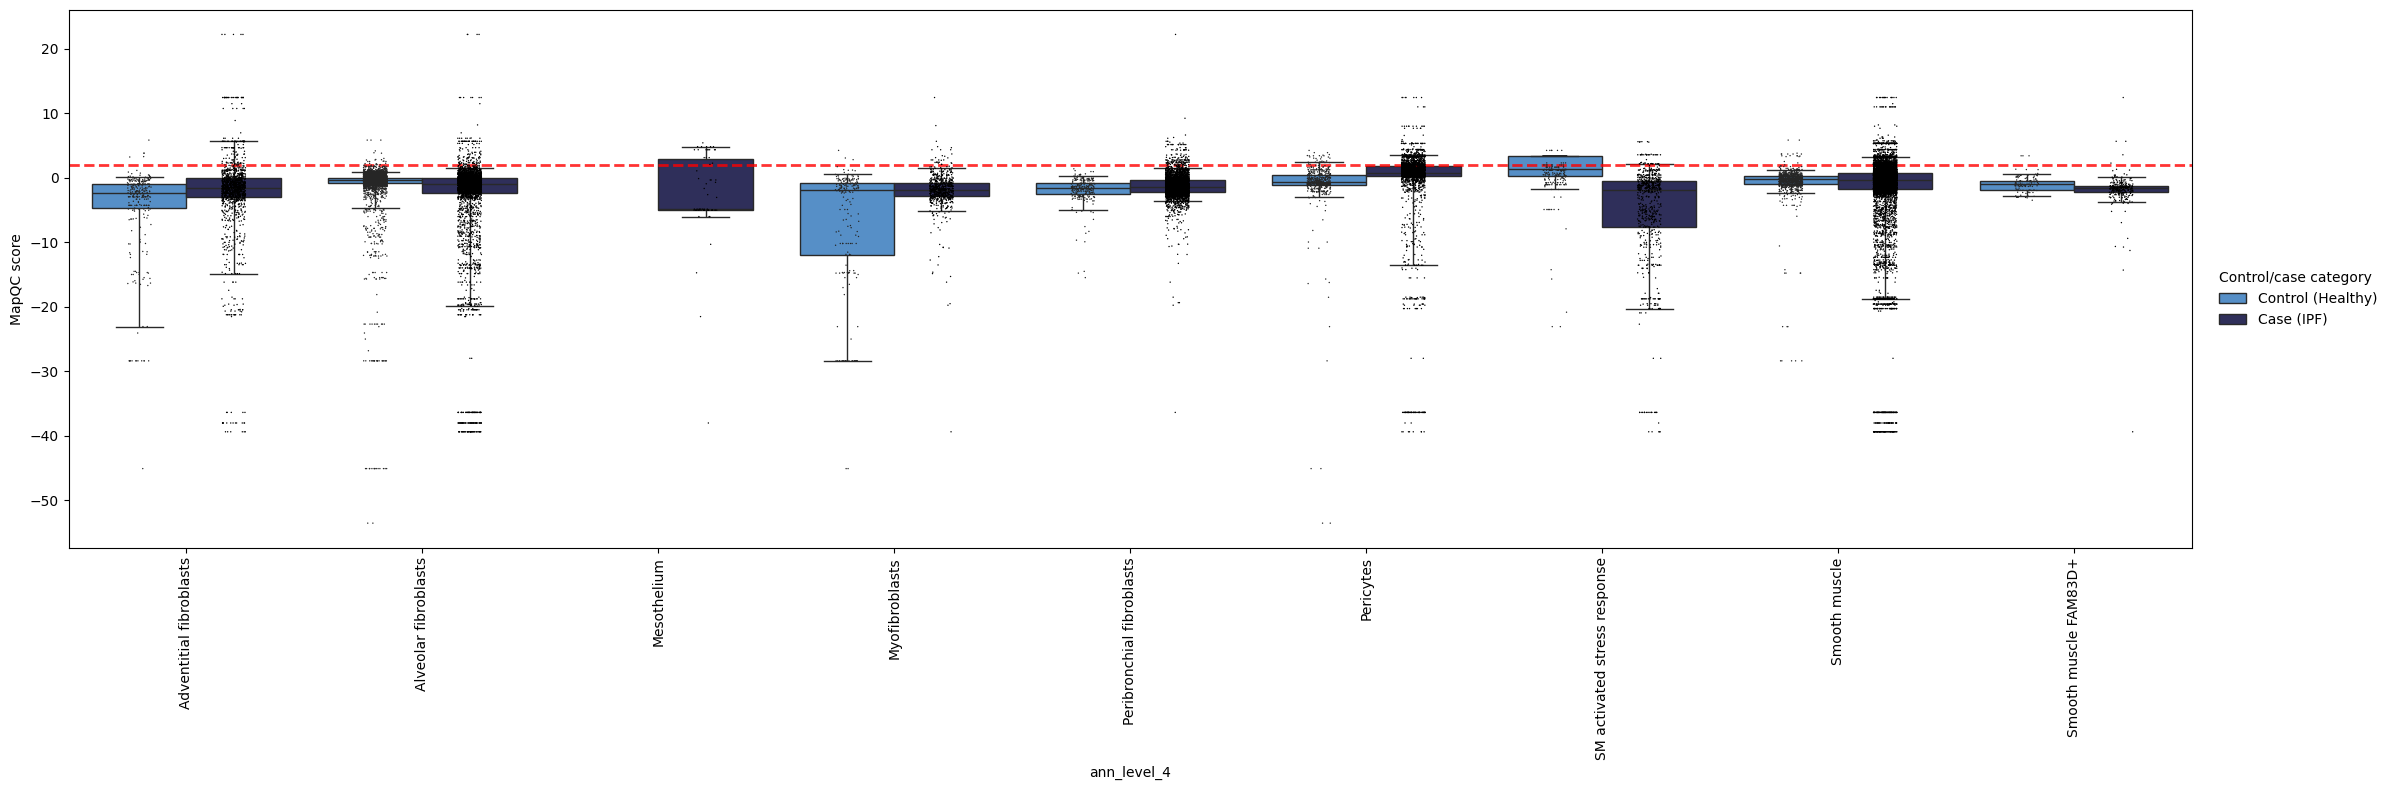

In [12]:
mapqc.pl.boxplot.mapqc_scores(adata, grouping_key="ann_level_4")

Using these plots, you can explore the mapping quality of your query. By grouping the scores in different ways, e.g. by cluster, coarse cell type annotation, or fine cell type annotations, you can get a better understaning of if and where the mapping might have failed, and/or where you observe disease-specific phenotypes.

Here's one more example, now showing mapqc_scores by cluster. In our case, this is less informative, as our clusters are rather coarse.

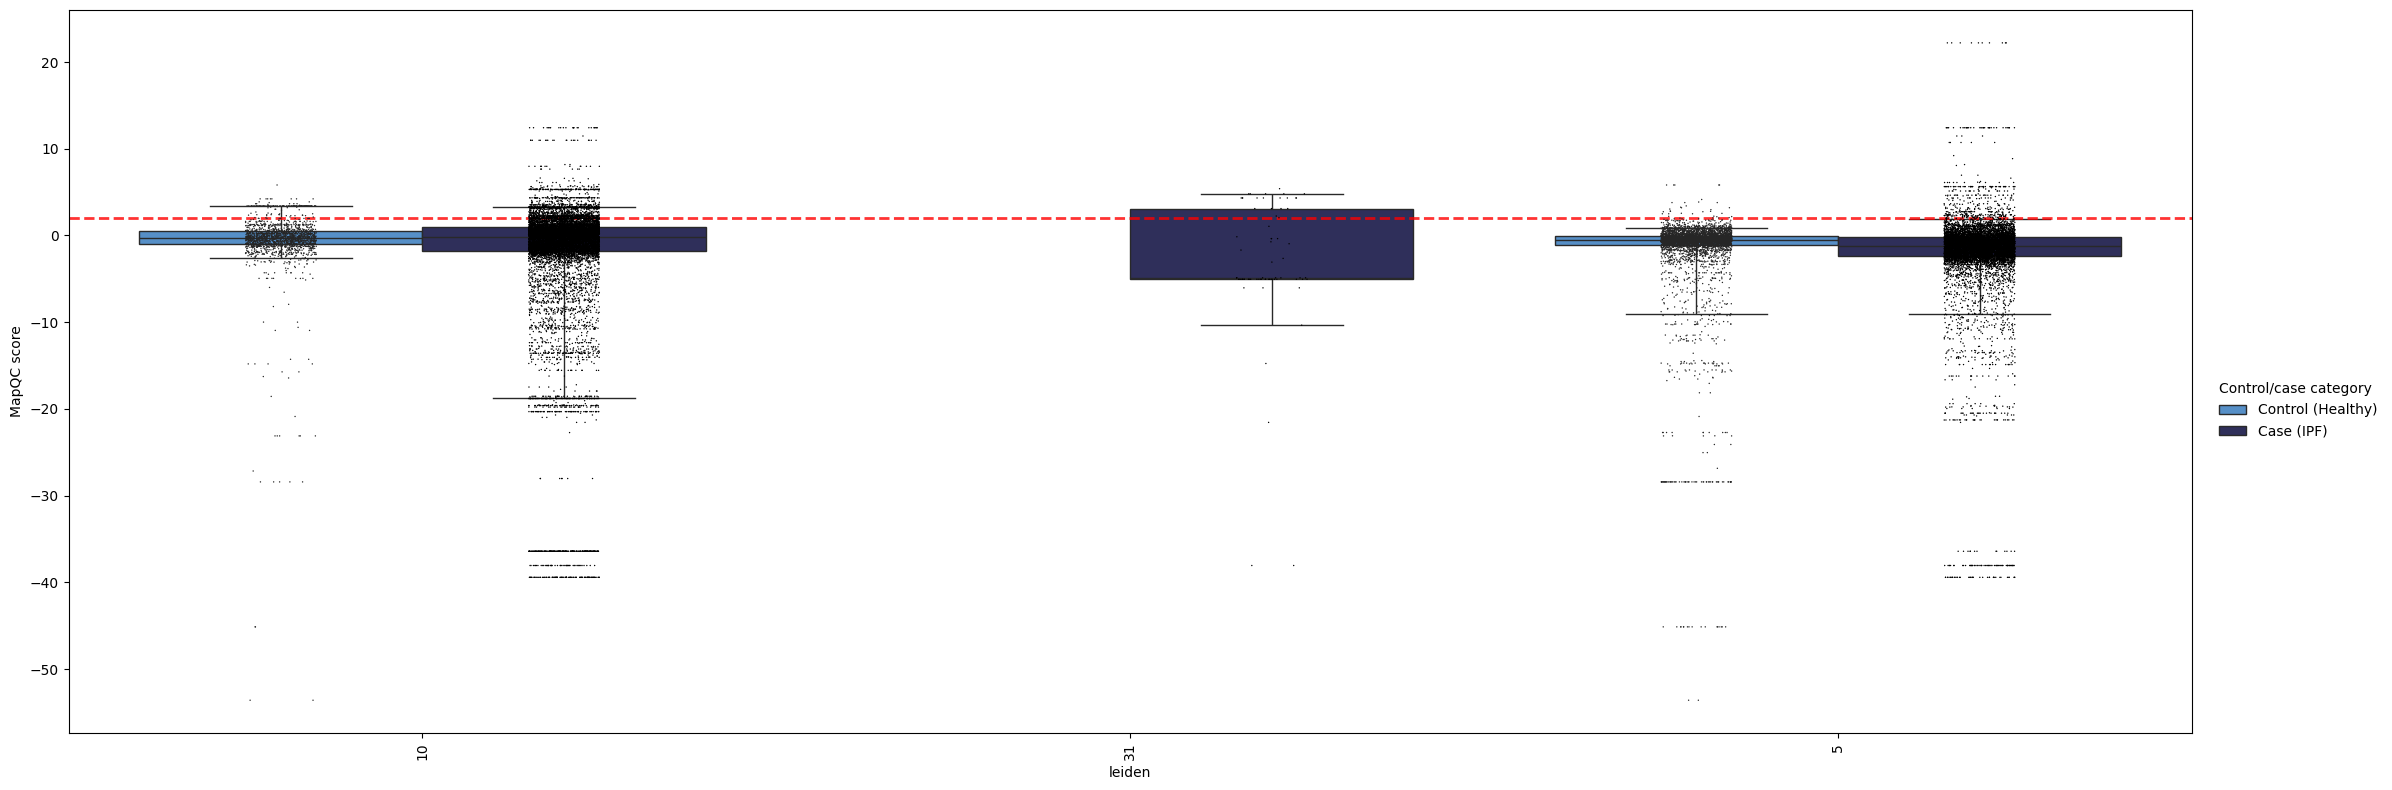

In [13]:
mapqc.pl.boxplot.mapqc_scores(adata, grouping_key="leiden")

That was a quick introduction to mapQC! For more details, check out the [mapqc_detailed](./mapqc_detailed.ipynb) tutorial notebook. In case of questions, do not hesitate to submit an issue on our GitHub :) 